<a href="https://colab.research.google.com/github/rajagurunath/PowerGenForecast/blob/master/powerGenForecastv5_datasetB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls

logs2					model-ep012-loss0.337-val_loss1.879.h5
model-ep001-loss0.604-val_loss0.482.h5	model-ep013-loss0.267-val_loss1.921.h5
model-ep001-loss0.607-val_loss0.572.h5	model-ep013-loss0.272-val_loss2.554.h5
model-ep002-loss0.454-val_loss0.731.h5	model-ep014-loss0.272-val_loss1.885.h5
model-ep002-loss0.468-val_loss0.478.h5	model-ep014-loss0.281-val_loss1.390.h5
model-ep003-loss0.404-val_loss2.242.h5	model-ep015-loss0.172-val_loss1.910.h5
model-ep003-loss0.406-val_loss3.095.h5	model-ep015-loss0.172-val_loss2.315.h5
model-ep004-loss0.266-val_loss5.033.h5	model-ep016-loss0.272-val_loss2.402.h5
model-ep004-loss0.273-val_loss7.776.h5	model-ep016-loss0.280-val_loss2.613.h5
model-ep005-loss0.309-val_loss3.272.h5	model-ep017-loss0.354-val_loss2.603.h5
model-ep005-loss0.332-val_loss3.554.h5	model-ep017-loss0.389-val_loss2.627.h5
model-ep006-loss0.151-val_loss2.425.h5	model-ep018-loss0.618-val_loss2.742.h5
model-ep006-loss0.162-val_loss2.351.h5	model-ep018-loss0.629-val_loss2.565.h5
model-ep007-los

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
#import path
import sys

In [0]:
plt.style.use('seaborn-notebook')

In [4]:
tf.__version__,pd.__version__

('1.13.1', '0.24.2')

In [0]:
DATA_DIR='https://github.com/rajagurunath/PowerGenForecast/blob/master/data/Dataset_B.xlsx?raw=true'
electric_df=pd.read_excel(DATA_DIR)

In [6]:
electric_df.head()

,Timestamp,Actual_Power Generation [kW],Wind Speed [m/s]
0,2017-09-02 00:00:00,9904.0,4.71047
1,2017-09-02 00:15:00,7084.0,4.21302
2,2017-09-02 00:30:00,10440.0,3.71556
3,2017-09-02 00:45:00,6900.0,3.99065
4,2017-09-02 01:00:00,12730.0,4.26575


In [7]:
electric_df.columns

Index(['Timestamp', 'Actual_Power Generation [kW]', 'Wind Speed [m/s]'], dtype='object')

In [0]:
datetime_col='Timestamp'
power_col='Actual_Power Generation [kW]'
windspeed_col='Wind Speed [m/s]'

In [0]:
electric_df.set_index(pd.to_datetime(electric_df[datetime_col]),inplace=True)

In [10]:
electric_df.iloc[:,:].isna().sum()

Timestamp                          0
Actual_Power Generation [kW]    2905
Wind Speed [m/s]                6048
dtype: int64

In [0]:
electric_df=electric_df.fillna(electric_df.mean())

## Ploting

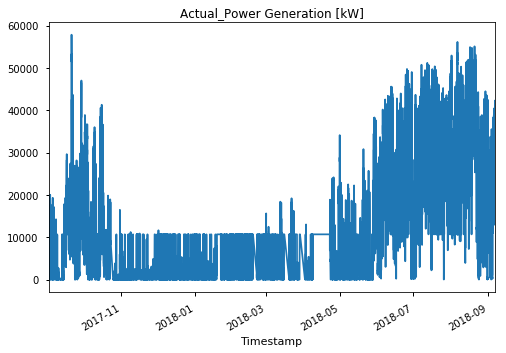

In [12]:
electric_df[power_col].plot(title=power_col)
plt.show()

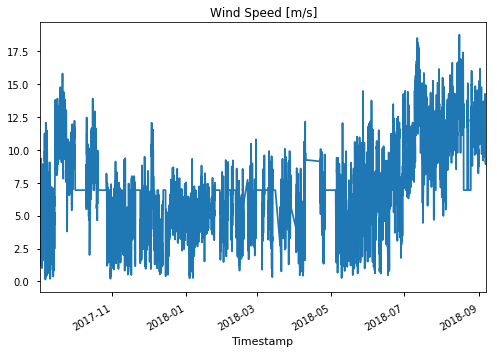

In [13]:
electric_df[windspeed_col].plot(title=windspeed_col)
plt.show()

# Monthwise

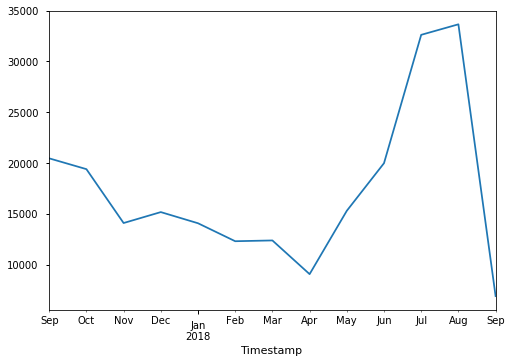

In [14]:
electric_df.resample('1m').sum()[windspeed_col].plot()

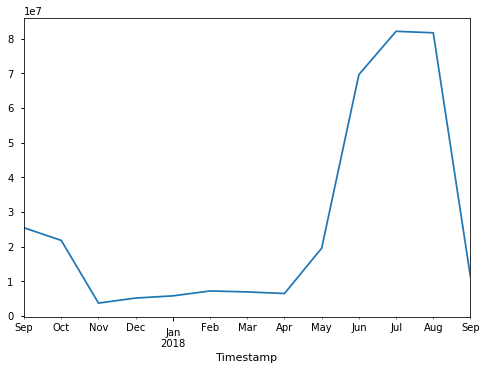

In [15]:
electric_df.resample('1m').sum()[power_col].plot()

# Weekly

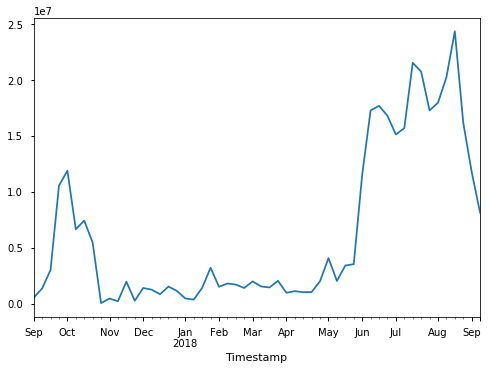

In [16]:
electric_df.resample('1w').sum()[power_col].plot()

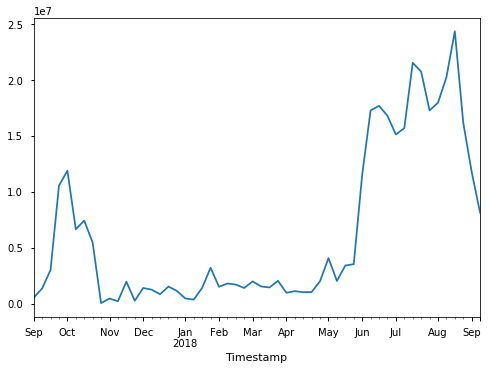

In [17]:
electric_df.resample('1w').sum()[power_col].plot()

# Daywise

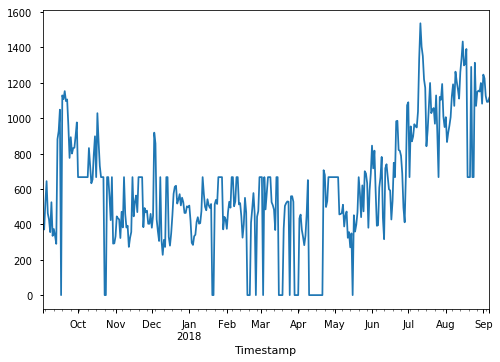

In [18]:
electric_df.resample('1D').sum()[windspeed_col].plot()

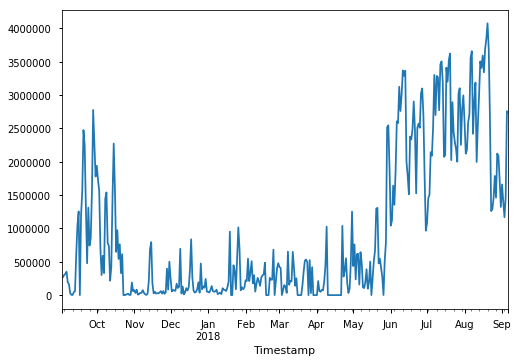

In [19]:
electric_df.resample('1D').sum()[power_col].plot()

# Train -test Split

In [20]:
electric_df[power_col].values.reshape(1,-1)

array([[ 9904.,  7084., 10440., ..., 31752., 30409., 31256.]])

In [0]:
from sklearn.preprocessing import StandardScaler,Normalizer
scalar=StandardScaler()
scaled=scalar.fit_transform(electric_df[[windspeed_col,power_col]].values)

electric_df['PowerGenScaled']=scaled[:,0]
electric_df['WindSpeedScaled']=scaled[:,1]

In [0]:
electric_df=electric_df.sort_index()

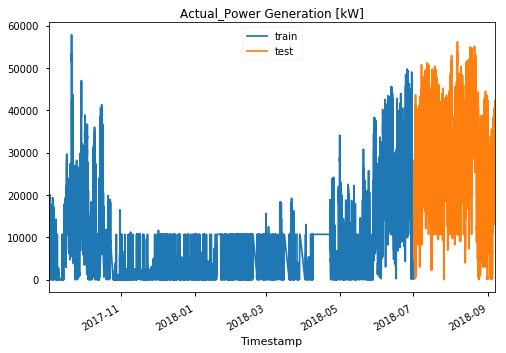

In [23]:
train=electric_df[:int(len(electric_df)*0.8)]
test=electric_df[int(len(electric_df)*0.8):]
train[power_col].plot(label='train')
test[power_col].plot(label='test')
plt.title(power_col)
plt.legend()
plt.show()

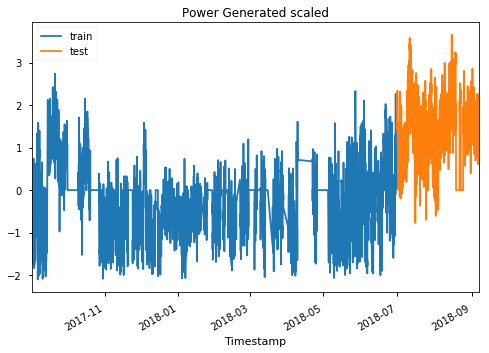

In [24]:
train['PowerGenScaled'].plot(label='train')
test['PowerGenScaled'].plot(label='test')
plt.title('Power Generated scaled')
plt.legend()
plt.show()

# Neural Networks-Model Building

## Approach 1 -Treating power Generated as Sequence

In [0]:
#@title Train config
INP_SEQ = 96 #@param {type:raw}'

OUT_SEQ=96 #@param {type:raw}'

In [0]:
power=train['PowerGenScaled'].values
wind=train['WindSpeedScaled'].values

def powerG():
    inp_l=[]
    out_l=[]
    for i in range(power.shape[0]-(OUT_SEQ)):
        yield (wind[i:i+INP_SEQ].reshape(1,-1),power[i:i+OUT_SEQ].reshape(1,-1))
        
def prepare_data(W,P):
    print(W.shape)
    inp_l=[]
    out_l=[]
    for i in range(W.shape[0]-(OUT_SEQ)):
        inp_l.append(W[i:i+INP_SEQ])
        out_l.append(P[i:i+OUT_SEQ])
    X=np.array(inp_l)
    Y=np.array(out_l)
    return X,Y

In [27]:
X,Y=prepare_data(wind,power)

(25958,)


ludwigdf=pd.DataFrame({'inp_ts':[X],'out_ts':[Y]},index=range(len(X)))
ludwigdf.to_csv(DIR+'/ludwig_ts.csv')

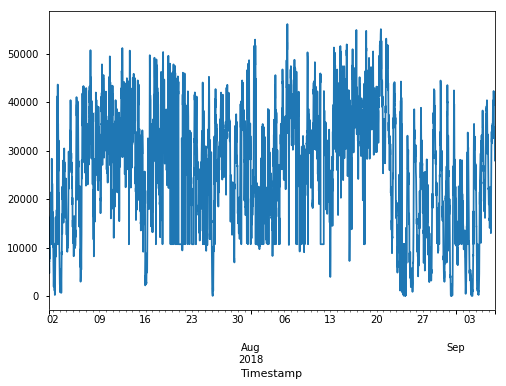

In [28]:
test[power_col][test[power_col].isna()]
test[power_col].plot()

In [0]:
arraytest=test['PowerGenScaled'].values
powertest=test['PowerGenScaled'].values
windtest=test['WindSpeedScaled'].values


def powerGtest(use_as_iter=True):
    if use_as_iter:
        for i in range(powertest.shape[0]-(OUT_SEQ)):
            yield (windtest[i:i+INP_SEQ].reshape(1,-1),powertest[i:i+OUT_SEQ].reshape(1,-1))
def inference():
    inp_l=[]
    out_l=[]
    for i in range(powertest.shape[0]-(OUT_SEQ)):
        inp_l.append(windtest[i:i+INP_SEQ])
        out_l.append(powertest[i:i+OUT_SEQ])
    X=np.array(inp_l)
    Y=np.array(out_l)
    return X,Y
#xt,yt=powerGtest()

In [30]:
dstest=tf.data.Dataset.from_generator(powerGtest,(tf.float32,tf.float32),(tf.TensorShape([1,96]),tf.TensorShape([1,96])))

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [0]:
ds=tf.data.Dataset.from_generator(powerG,(tf.float32,tf.float32),(tf.TensorShape([1,96]),tf.TensorShape([1,96])))

In [0]:
value=ds.make_one_shot_iterator().get_next()

In [33]:
sess=tf.Session()
sess.run(value)

(array([[-0.05872517, -0.27275908, -0.01804355, -0.2867244 ,  0.15576412,
          0.4704395 ,  0.4956378 ,  0.15083072, -0.224184  , -0.28854597,
         -0.30068973, -0.43457475, -0.6045875 , -0.76351905, -0.8045043 ,
         -0.8104244 , -0.8089064 , -0.8104244 , -0.8104244 , -0.8104244 ,
         -0.8104244 , -0.8104244 , -0.8090582 , -0.8104244 , -0.8104244 ,
         -0.8104244 , -0.8104244 , -0.8104244 , -0.8104244 , -0.8104244 ,
         -0.8104244 , -0.8104244 , -0.8104244 , -0.8104244 , -0.8104244 ,
         -0.8104244 , -0.8104244 , -0.8104244 , -0.8104244 , -0.8104244 ,
         -0.8104244 , -0.8104244 , -0.8104244 , -0.8104244 , -0.8104244 ,
         -0.8104244 , -0.8104244 , -0.8104244 , -0.8104244 , -0.8104244 ,
         -0.8104244 , -0.8104244 , -0.8104244 , -0.8104244 , -0.8104244 ,
         -0.8104244 , -0.8104244 , -0.8104244 , -0.8104244 , -0.8104244 ,
         -0.786744  , -0.6724408 , -0.43563735, -0.13113238, -0.08225372,
         -0.22403221, -0.2648656 , -0.

In [0]:
class windToPower(tf.keras.Model):
    def __init__(self, outseq,num_units=192,batch_size=1):
        super().__init__()
        self.outseq = outseq
        self.batch_size=batch_size
        self.cell = tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell',num_units=num_units)
        self.dense = tf.keras.layers.Dense(units=self.outseq)

    def call(self, inputs):
        state = self.cell.zero_state(batch_size=self.batch_size, dtype=tf.float32)
        output,state=self.cell(inputs,state)
        output=self.dense(output)
        return output

In [35]:
lstm=windToPower(num_units=INP_SEQ,outseq=OUT_SEQ)
lstm.compile('adam',loss='mse')

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.


In [36]:
TB=tf.keras.callbacks.TensorBoard('./logs2',histogram_freq=10,write_grads=True,batch_size=32,write_graph=True)
ES=tf.keras.callbacks.EarlyStopping(patience=20)
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

MC=tf.keras.callbacks.ModelCheckpoint(filepath,save_weights_only=True)
#lstm.load_weights('./lstm2.h5')
history=lstm.fit(ds,epochs=50,steps_per_epoch=500,validation_data=dstest,validation_steps=10,callbacks=[ES,MC,TB])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
500/500 [==============================] - 1s 3ms/step - loss: 0.5432 - val_loss: 2.1555
Epoch 2/50
500/500 [==============================] - 1s 2ms/step - loss: 0.4694 - val_loss: 1.8287
Epoch 3/50
500/500 [==============================] - 1s 2ms/step - loss: 0.3264 - val_loss: 1.6087
Epoch 4/50
500/500 [==============================] - 1s 2ms/step - loss: 0.2161 - val_loss: 0.3240
Epoch 5/50
500/500 [==============================] - 1s 2ms/step - loss: 0.2240 - val_loss: 0.3288
Epoch 6/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0780 - val_loss: 0.0319
Epoch 7/50
500/500 [==============================] - 1s 3ms/step - loss: 0.0306 - val_loss: 0.0582
Epoch 8/50
500/500 [==============================] - 1s 2ms/step - loss: 0.1922 - val_loss: 0.1710
Epoch 9/50
500/500 [==============================] - 1s 2ms/step - loss: 0.2436 - val_loss: 0.1501
Epoc

In [37]:
!ls

logs2					model-ep013-loss0.267-val_loss1.921.h5
model-ep001-loss0.543-val_loss2.155.h5	model-ep013-loss0.272-val_loss0.362.h5
model-ep001-loss0.604-val_loss0.482.h5	model-ep013-loss0.272-val_loss2.554.h5
model-ep001-loss0.607-val_loss0.572.h5	model-ep014-loss0.272-val_loss1.885.h5
model-ep002-loss0.454-val_loss0.731.h5	model-ep014-loss0.276-val_loss0.635.h5
model-ep002-loss0.468-val_loss0.478.h5	model-ep014-loss0.281-val_loss1.390.h5
model-ep002-loss0.469-val_loss1.829.h5	model-ep015-loss0.172-val_loss1.910.h5
model-ep003-loss0.326-val_loss1.609.h5	model-ep015-loss0.172-val_loss2.315.h5
model-ep003-loss0.404-val_loss2.242.h5	model-ep015-loss0.182-val_loss0.419.h5
model-ep003-loss0.406-val_loss3.095.h5	model-ep016-loss0.233-val_loss0.531.h5
model-ep004-loss0.216-val_loss0.324.h5	model-ep016-loss0.272-val_loss2.402.h5
model-ep004-loss0.266-val_loss5.033.h5	model-ep016-loss0.280-val_loss2.613.h5
model-ep004-loss0.273-val_loss7.776.h5	model-ep017-loss0.217-val_loss0.637.h5
model-ep005-los

# Tensorboard visualization

In [38]:
LOG_DIR = 'logs2'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip


--2019-04-26 12:34:44--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.203.66.95, 52.55.191.55, 3.92.108.98, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.203.66.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14991793 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.2’

ngrok-stable-linux- 100%[===================>]  14.30M  64.8MB/s    in 0.2s    

2019-04-26 12:34:44 (64.8 MB/s) - ‘ngrok-stable-linux-amd64.zip.2’ saved [14991793/14991793]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: ngrok                   


***Tensorboard link ***

In [39]:
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


https://f2a681ab.ngrok.io


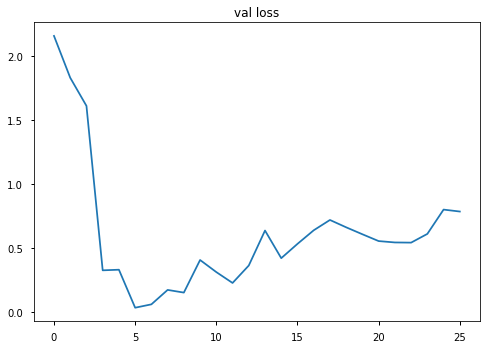

In [40]:
plt.plot(lstm.history.history['val_loss'])
plt.title('val loss')
plt.show()

In [41]:
lstm.evaluate(dstest,steps=100)

100/100 [==============================] - 0s 877us/step - loss: 0.3210


0.3209879744797945

In [0]:
predicted=lstm.predict(dstest,steps=1)

In [43]:
predicted.shape

(1, 96)

# inference or prediction time

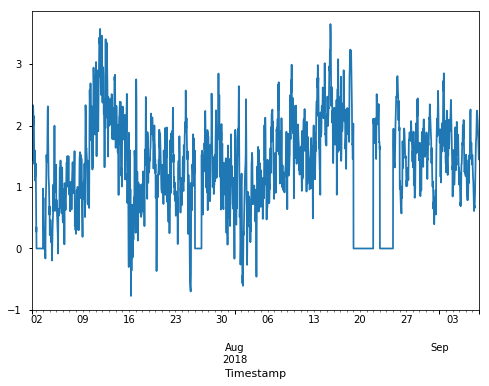

In [44]:
test['PowerGenScaled'].plot()

In [0]:
predicted=lstm.predict_on_batch(dstest)

In [0]:
testiter=dstest.make_one_shot_iterator()
x,y=testiter.get_next()

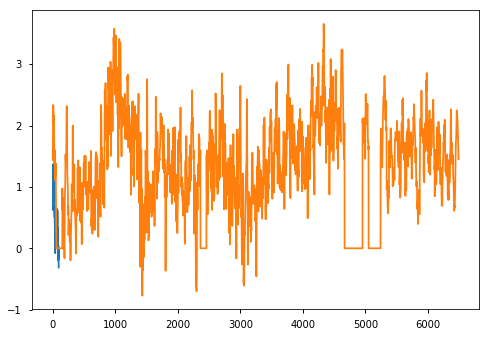

In [47]:
plt.plot(predicted.reshape(-1))
plt.plot(test['PowerGenScaled'].values)
plt.show()

In [0]:
xtest,ytest=inference()
#lstm.predict(X)

In [49]:
xtest.shape,ytest.shape,xtest[0].reshape(1,-1).shape

((6394, 96), (6394, 96), (1, 96))

# *Prediction for last 10 days*

In [0]:
from sklearn.metrics import mean_absolute_error,mean_squared_error


In [51]:
predicted.shape,xtest.shape,predicted.shape,xtest[1].shape
#scalar.inverse_transform([xtest[ithday],predicted[ithday-1]])

((1, 96), (6394, 96), (1, 96), (96,))

In [52]:

scalar.inverse_transform(np.array([xtest[1],predicted.reshape(-1)]).reshape(96,-1))

array([[5.98918081e+00, 5.52300000e+03],
       [5.47601555e+00, 7.23600000e+03],
       [6.07258243e+00, 7.47800000e+03],
       [6.33848642e+00, 9.86600000e+03],
       [6.52883836e+00, 9.29000000e+03],
       [6.35516675e+00, 7.69800000e+03],
       [6.99000026e+00, 1.26160000e+04],
       [7.04740020e+00, 1.10860000e+04],
       [7.10136595e+00, 1.14000000e+04],
       [7.77691907e+00, 1.62000000e+04],
       [6.94381845e+00, 1.41416700e+04],
       [8.38501501e+00, 1.06777325e+04],
       [8.81208036e+00, 1.46700000e+04],
       [8.85721536e+00, 2.07699900e+04],
       [8.75418982e+00, 1.98460000e+04],
       [9.57520519e+00, 1.91860000e+04],
       [8.08337833e+00, 1.38740000e+04],
       [8.34012531e+00, 1.06777325e+04],
       [9.91331045e+00, 2.79670000e+04],
       [1.12758623e+01, 2.62000000e+04],
       [1.02971198e+01, 2.33050000e+04],
       [9.42311988e+00, 1.91280000e+04],
       [9.61200002e+00, 2.32103400e+04],
       [9.96326802e+00, 2.20200000e+04],
       [9.554354

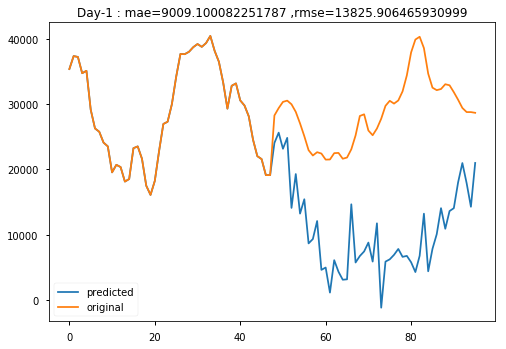

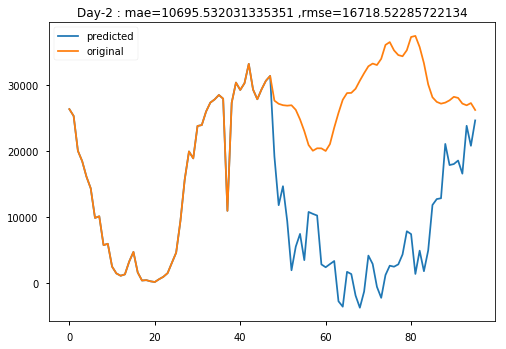

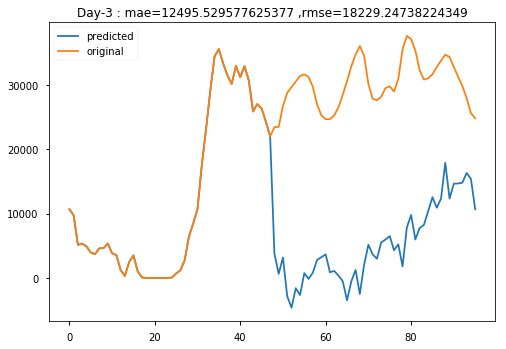

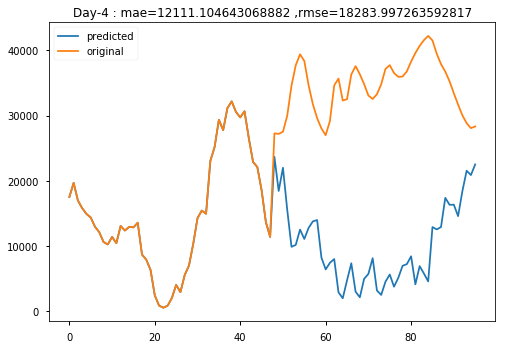

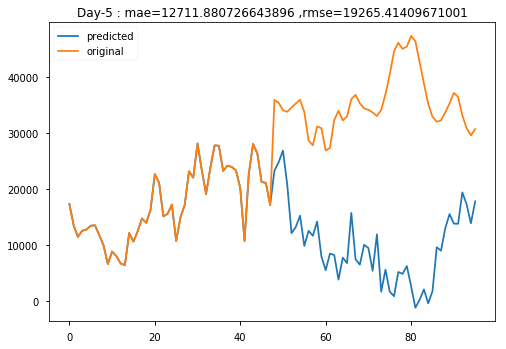

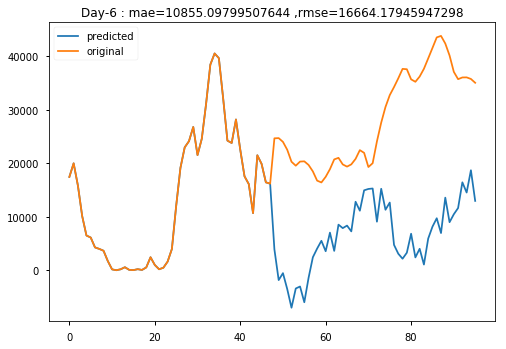

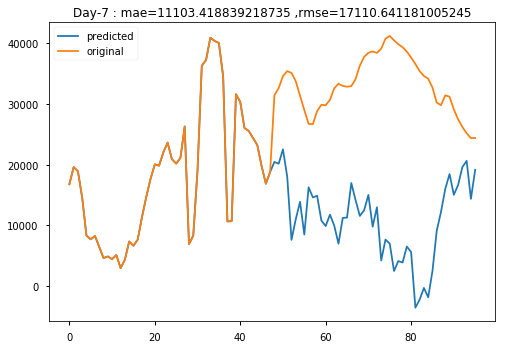

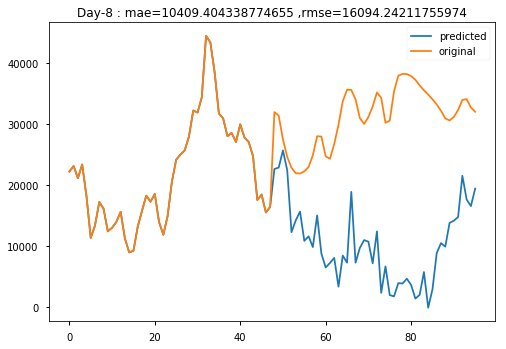

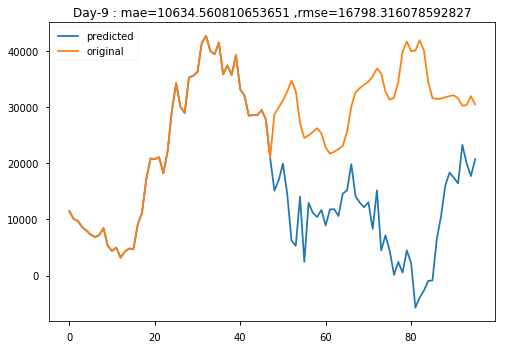

In [53]:
for i in range(1,10):
  ithday=len(xtest)-96*i
  predicted=lstm.predict(xtest[ithday].reshape(1,-1))
  original=ytest[ithday]
  
  original=scalar.inverse_transform(np.array([xtest[ithday],original.reshape(-1)]).reshape(OUT_SEQ,-1))[:,1]
  predicted=scalar.inverse_transform(np.array([xtest[ithday],predicted.reshape(-1)]).reshape(OUT_SEQ,-1))[:,1]
  
  plt.plot(predicted.reshape(-1),label='predicted')
  plt.plot(original,label='original')
  mae=mean_absolute_error(original,predicted.reshape(-1))
  rmse=mean_squared_error(original,predicted.reshape(-1))**0.5
  plt.title('Day-{} : mae={} ,rmse={}'.format(i,mae,rmse))
  plt.legend()
  plt.show()

In [54]:
lstm_est=tf.keras.estimator.model_to_estimator(lstm)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp8fgmeo51', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f091ebcbb00>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replica

lstmestimator=tf.keras.estimator.model_to_estimator(keras_model=lstm)